In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
nltk.download('punkt')
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from nltk.tokenize import word_tokenize
import re
import os

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Data loading & cleaning

**1. Download at least 3000 Tweets by calling Twitter's API (or from any other source), and save them into
a corpus**

In [38]:
from google.colab import drive
drive.mount('/content/drive')
file_path = '/content/drive/My Drive/training.1600000.processed.noemoticon.csv'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [39]:
# Load 3200 Tweets
df = pd.read_csv(file_path, encoding='ISO-8859-1')
df = df.iloc[:, [5, 0]]
df.columns = ["text", "label"]
df["label"] = df["label"].apply(lambda x: 1 if x==4 else 0)
df = df.sample(n=3200, random_state=42)
df = df.drop_duplicates()
df.reset_index(inplace=True, drop=True)
df.head()

,text,label
0,@Nkluvr4eva My poor little dumpling In Holmde...,0
1,I'm off too bed. I gotta wake up hella early t...,0
2,I havent been able to listen to it yet My spe...,0
3,now remembers why solving a relatively big equ...,0
4,"Ate too much, feel sick",0


We do the following things to make the text clean:</br>
*  Remove mentions (@)
*  Remove numbers
*  Remove URLs
*  Remove special characters



In [40]:
# Data cleaning
class TwitterCleaning():
  def __init__(self, df):
        self.processed_df = df
  @staticmethod
  def remove_by_pattern(tweet, pattern):
    return tweet["text"].apply(lambda x: pattern.sub("", x))
  def remove_mentions(self, tweet):
    return self.remove_by_pattern(tweet, re.compile(r"@[^\s]+[\s]?"))
  def remove_numbers(self, tweet):
    return self.remove_by_pattern(tweet, re.compile(r"\s?[0-9]+\.?[0-9]*"))
  def remove_urls(self, tweet):
    return self.remove_by_pattern(tweet, re.compile(r"\b(?:https?://)?(?:www\.)?[a-zA-Z0-9-]+(?:\.[a-zA-Z]{2,})+(?:/[^\s]*)?\b"))
  def remove_special_characters(self, tweet):
    return self.remove_by_pattern(tweet, re.compile(r'[^\w\s]'))
  def remove_nonalphabet_characters(self, tweet):
    return self.remove_by_pattern(tweet, re.compile(r'[^a-zA-Z\s]+'))
  def cleanup(self):
    tweets = self.processed_df
    for cleanup_method in [self.remove_mentions, self.remove_urls, self.remove_nonalphabet_characters]:
      tweets["text"] = cleanup_method(tweets)
    self.processed_df = tweets

In [41]:
df = TwitterCleaning(df)
df.cleanup()
df = df.processed_df
df = df[df["text"].str.len() >= 3] # delete rows with length < 3
df.head()

,text,label
0,My poor little dumpling In Holmdel vids he wa...,0
1,Im off too bed I gotta wake up hella early tom...,0
2,I havent been able to listen to it yet My spe...,0
3,now remembers why solving a relatively big equ...,0
4,Ate too much feel sick,0


In [42]:
df.isnull().value_counts()

text   label
False  False    3190
Name: count, dtype: int64

In [43]:
# Test the balance of labels
# 0: negative; 1: positive
df["label"].value_counts(normalize = True)

label
1    0.503448
0    0.496552
Name: proportion, dtype: float64

## Data Exploratory Analysis

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


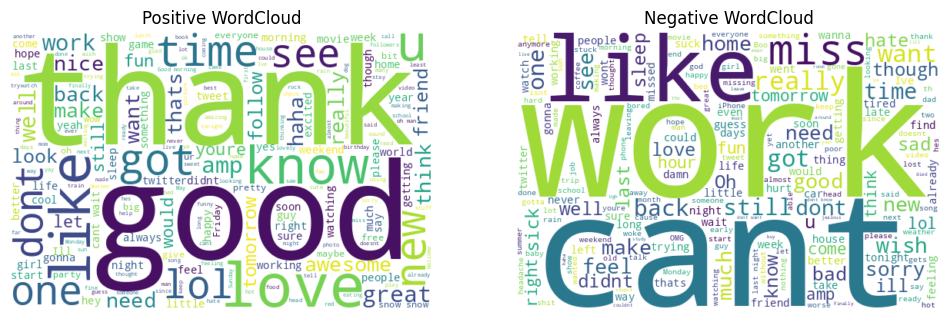

In [44]:
# Create wordCloud for two groups
from wordcloud import WordCloud
from nltk.corpus import stopwords

pos_text = ""
neg_text = ""
df_pos = df.loc[df[df["label"] == 1].index]["text"]
df_neg =df.loc[df[df["label"] == 0].index]["text"]
for sentence in df_pos:
  pos_text += sentence
for sentence in df_neg:
  neg_text += sentence

nltk.download('stopwords')
stopwords_nltk = set(stopwords.words('english'))
stopwords_custom = set({"Im", "day", "today", "going", "go", "get"})
stopwords = stopwords_nltk | stopwords_custom

wordcloud_pos = WordCloud(stopwords=stopwords, width=550, height=360, background_color='white').generate(pos_text)
wordcloud_neg = WordCloud(stopwords=stopwords, width=550, height=360, background_color='white').generate(neg_text)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(wordcloud_pos, interpolation='bilinear')
axes[0].axis('off')
axes[0].set_title('Positive WordCloud')

axes[1].imshow(wordcloud_neg, interpolation='bilinear')
axes[1].axis('off')
axes[1].set_title('Negative WordCloud')

plt.show()

In [45]:
def wordList(text_array):
  words_dict = {}
  for i in range(len(text_array)):
    s = text_array[i].split()
    for j in range(len(s)):
      words_dict[s[j]] = words_dict.get(s[j],0)+1
  words_i = sorted([(v, k) for k, v in words_dict.items()])[::-1]
  total = []
  for i in range(len(words_i)):
      if i >= 10:
        total.append(words_i[i][1])
        if len(total) == 30: break
  return total

df_train = pd.DataFrame({"sentence": df["text"], "label": df["label"]})

l = []
for i in range(2):
  d_i = df_train[df_train["label"] == i]
  l_i = wordList(np.array(d_i["sentence"]))
  l.append(l_i)

l0 = []
l1 = []
for i in range(30):
  if l[0][i] not in l[1]:
        l0.append(l[0][i])
  if l[1][i] not in l[0]:
        l1.append(l[1][i])

print('Frequent words in positive sentences: {}'.format(l1))
print('Frequent words in negative sentences: {}'.format(l0))

Frequent words in positive sentences: ['in', 'i', 'are', 'day', 'your', 'good', 'love', 'from', 'do']
Frequent words in negative sentences: ['for', 'you', 'not', 'go', 'work', 'no', 'dont', 'cant', 'miss']


## Data preprocessing

**3. Split the corpus into a training set and a validation set**

In [46]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(df["text"], df["label"],
                                                  test_size=0.2,
                                                  stratify = df["label"],
                                                  random_state=42)

print('The number of samples in the train set: {}'.format(len(X_train)))
print('The number of samples in the validation set: {}'.format(len(X_val)))

The number of samples in the train set: 2552
The number of samples in the validation set: 638


**4. Embed text into digital format by TfidfVectorizer**

In [47]:
mean_len = np.mean(X_train.apply(lambda x: len(x)))
max_len = np.max(X_train.apply(lambda x: len(x)))
print("The mean length of sentences in the dataset is", mean_len)
print("The max length of sentences in the dataset is", max_len)

The mean length of sentences in the dataset is 62.73040752351097
The max length of sentences in the dataset is 143


<Axes: >

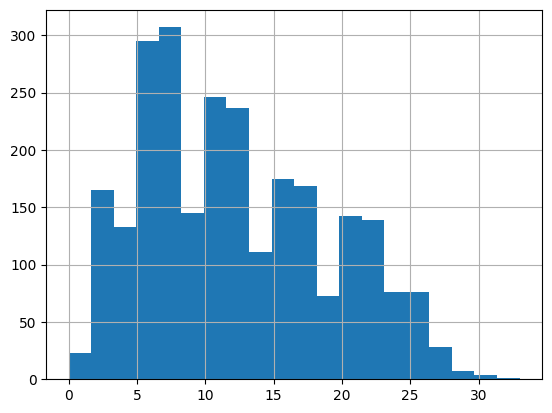

In [48]:
# Distribution of length of sentences
seq_len = pd.Series([len(i.split()) for i in X_train])
seq_len.hist(bins = 20)

In [49]:
# Vectorization
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_val_tfidf = vectorizer.transform(X_val)

## Model Construction and Evaluation

**5. Build three classifiers; Optimize model parameters** </br>
**6. Compare the model performance using precision/recall & ROC, and apply cross validation**

In [50]:
model_results = dict()

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Best parameters for Logistic Regression: {'C': 1}
Classification report for Logistic Regression:
              precision    recall  f1-score   support

           0       0.75      0.72      0.73       317
           1       0.73      0.76      0.75       321

    accuracy                           0.74       638
   macro avg       0.74      0.74      0.74       638
weighted avg       0.74      0.74      0.74       638

ROC AUC for Logistic Regression: 0.7849582829682479


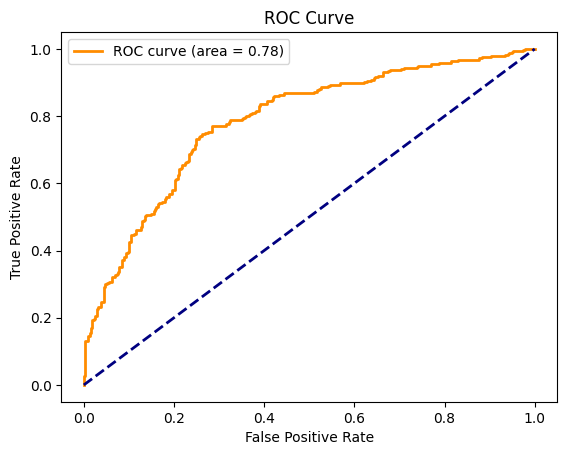

Best parameters for SVM: {'C': 1, 'kernel': 'rbf'}
Classification report for SVM:
              precision    recall  f1-score   support

           0       0.73      0.73      0.73       317
           1       0.73      0.73      0.73       321

    accuracy                           0.73       638
   macro avg       0.73      0.73      0.73       638
weighted avg       0.73      0.73      0.73       638

ROC AUC for SVM: 0.7884568137818531


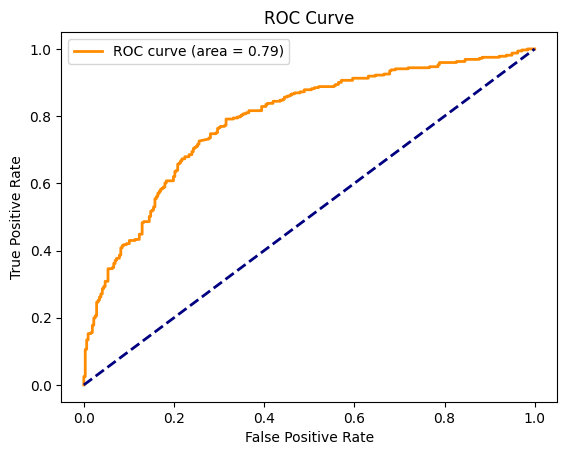

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomFor

Best parameters for Random Forest: {'max_features': 'log2', 'n_estimators': 300}
Classification report for Random Forest:
              precision    recall  f1-score   support

           0       0.71      0.68      0.70       317
           1       0.70      0.73      0.71       321

    accuracy                           0.70       638
   macro avg       0.70      0.70      0.70       638
weighted avg       0.70      0.70      0.70       638

ROC AUC for Random Forest: 0.7622817103491651


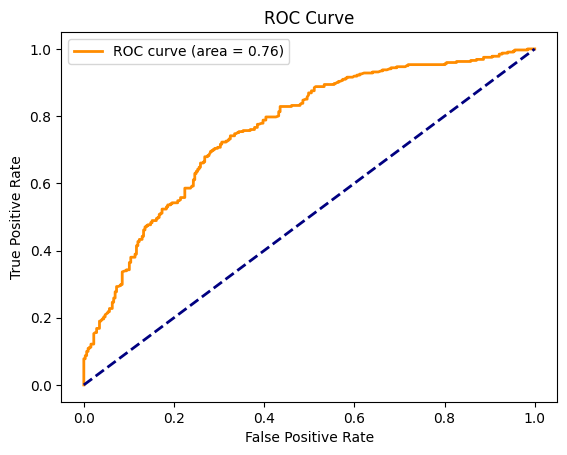

In [51]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, auc, precision_score, recall_score, accuracy_score, f1_score

# Three classifiers
models = {
    'Logistic Regression': LogisticRegression(random_state=42),
    'SVM': SVC(probability=True, random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42)
}

# Model parameters
param_grids = {
    'Logistic Regression': {'C': [0.01, 0.1, 1, 10, 100]},
    'SVM': {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']},
    'Random Forest': {'n_estimators': [100, 200, 300], 'max_features': ['auto', 'sqrt', 'log2']}
}

# Function to plot ROC Curve
def plot_roc_curve(fpr, tpr, roc_auc, label=None):
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="best")
    plt.show()

# Function to evaluate the model and plot ROC curve
def model_evaluation(y_val, y_pred, y_proba):
  fpr, tpr, _ = roc_curve(y_val, y_proba, pos_label=None)
  roc_auc = auc(fpr, tpr)
  precision = precision_score(y_val, y_pred)
  recall = recall_score(y_val, y_pred)
  accuracy = accuracy_score(y_val, y_pred)
  f1 = f1_score(y_val, y_pred)

  print(f"Classification report for {name}:")
  print(classification_report(y_val, y_pred))

  if y_proba is not None:
        print(f"ROC AUC for {name}: {roc_auc}")
        plot_roc_curve(fpr, tpr, roc_auc, f"{name} (area = {roc_auc:.2f})")

  plt.show()

  return accuracy, precision, recall, f1, roc_auc, fpr, tpr

# Evaluating each model
for name, model in models.items():
    # Cross validation
    grid = GridSearchCV(model, param_grids[name], cv=5, scoring='accuracy')
    grid.fit(X_train_tfidf, y_train)
    print(f"Best parameters for {name}: {grid.best_params_}")
    best_model = grid.best_estimator_
    y_pred = best_model.predict(X_val_tfidf)
    y_proba = best_model.predict_proba(X_val_tfidf)[:, 1]
    accuracy, precision, recall, f1, roc_auc, fpr, tpr = model_evaluation(y_val, y_pred, y_proba)
    model_results[name] = [accuracy, precision, recall, f1, roc_auc, fpr, tpr]

**7. Improve the model performance**

Ensemble Methods with Voting Classifier

Classification report for Random Forest:
              precision    recall  f1-score   support

           0       0.72      0.74      0.73       317
           1       0.74      0.72      0.73       321

    accuracy                           0.73       638
   macro avg       0.73      0.73      0.73       638
weighted avg       0.73      0.73      0.73       638

ROC AUC for Random Forest: 0.7893117918177619


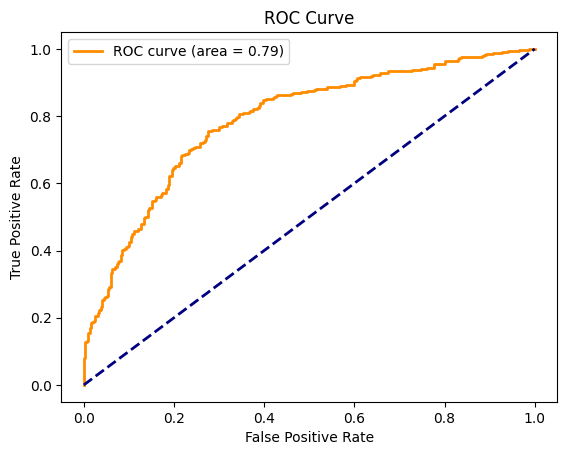

In [52]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import VotingClassifier, GradientBoostingClassifier
from sklearn.pipeline import Pipeline, FeatureUnion

# Advanced Feature Engineering: Using different n-gram ranges for TF-IDF
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 3))

# Models
lr = LogisticRegression(random_state=42)
svm = SVC(probability=True, random_state=42)
rf = RandomForestClassifier(n_estimators=300, random_state=42)
gb = GradientBoostingClassifier(n_estimators=100, random_state=42)

# Ensemble Method: Voting Classifier
voting_clf = VotingClassifier(
    estimators=[('lr', lr), ('svm', svm), ('rf', rf), ('gb', gb)],
    voting='soft'
)

# Pipeline for vectorization and voting classifier
pipeline = Pipeline([
    ('vectorizer', tfidf_vectorizer),
    ('classifier', voting_clf)
])

# Train the pipeline
pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_val)
y_proba = pipeline.predict_proba(X_val)[:, 1]

# Evaluate the model
accuracy, precision, recall, f1, roc_auc, fpr, tpr = model_evaluation(y_val, y_pred, y_proba)
model_results["Voting Classifier"] = [accuracy, precision, recall, f1, roc_auc, fpr, tpr]

Advanced Feature Engineering

In [53]:
from sklearn.base import TransformerMixin
from sklearn.model_selection import cross_val_score
import gensim.downloader as api

# Load pre-trained word vectors
word_vectors = api.load("glove-twitter-25")

class TfidfEmbeddingVectorizer(TransformerMixin):
    def __init__(self, word_vectors):
        self.word_vectors = word_vectors
        self.word2weight = None
        self.dim = word_vectors.vector_size
        self.max_idf = None

    def fit(self, X, y=None):
        tfidf = TfidfVectorizer(analyzer=lambda x: x)
        tfidf.fit(X)
        self.max_idf = max(tfidf.idf_)
        self.word2weight = {word: tfidf.idf_[i] for word, i in tfidf.vocabulary_.items()}
        return self

    def transform(self, X):
        return np.array([
            np.mean([self.word_vectors.get_vector(w) * self.word2weight.get(w, self.max_idf)
                     for w in words if w in self.word_vectors]
                    or [np.zeros(self.dim)], axis=0)
            for words in X
        ])

# Define individual classifiers
lr = LogisticRegression(random_state=42)
svm = SVC(probability=True, random_state=42)
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Create a voting classifier
voting_clf = VotingClassifier(
    estimators=[
        ('lr', lr),
        ('svm', svm),
        ('rf', rf)
    ],
    voting='soft'
)

# Pipeline setup
pipeline = Pipeline([
    ('word2vec vectorizer', TfidfEmbeddingVectorizer(word_vectors)),
    ('voting', voting_clf)
])

# Hyperparameter tuning setup
param_grid = {
    'voting__lr__C': [0.1, 1, 10],
    'voting__svm__C': [0.1, 1, 10],
    'voting__rf__n_estimators': [50, 100, 200]
}

grid_search = GridSearchCV(pipeline, param_grid, cv=5, verbose=1, scoring='accuracy')
grid_search.fit(X_train, y_train)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_}")

# Predictions and classification report
y_pred = grid_search.predict(X_val)
print(classification_report(y_val, y_pred))

[==================================================] 100.0% 104.8/104.8MB downloaded
Fitting 5 folds for each of 27 candidates, totalling 135 fits


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Best parameters: {'voting__lr__C': 10, 'voting__rf__n_estimators': 50, 'voting__svm__C': 0.1}
Best cross-validation score: 0.5673987951344921
              precision    recall  f1-score   support

           0       0.55      0.58      0.57       317
           1       0.56      0.53      0.55       321

    accuracy                           0.56       638
   macro avg       0.56      0.56      0.56       638
weighted avg       0.56      0.56      0.56       638



Neural Network

Epoch 1/10
256/256 [==============================] - 2s 3ms/step - loss: 0.6528 - accuracy: 0.6027
Epoch 2/10
256/256 [==============================] - 1s 3ms/step - loss: 0.4068 - accuracy: 0.8252
Epoch 3/10
256/256 [==============================] - 1s 3ms/step - loss: 0.1674 - accuracy: 0.9365
Epoch 4/10
256/256 [==============================] - 1s 3ms/step - loss: 0.0575 - accuracy: 0.9808
Epoch 5/10
256/256 [==============================] - 1s 3ms/step - loss: 0.0193 - accuracy: 0.9941
Epoch 6/10
256/256 [==============================] - 1s 3ms/step - loss: 0.0108 - accuracy: 0.9973
Epoch 7/10
256/256 [==============================] - 1s 3ms/step - loss: 0.0060 - accuracy: 0.9980
Epoch 8/10
256/256 [==============================] - 1s 3ms/step - loss: 0.0041 - accuracy: 0.9980
Epoch 9/10
256/256 [==============================] - 1s 3ms/step - loss: 0.0030 - accuracy: 0.9984
Epoch 10/10
20/20 [==============================] - 0s 2ms/step
Classification report for Random Fo

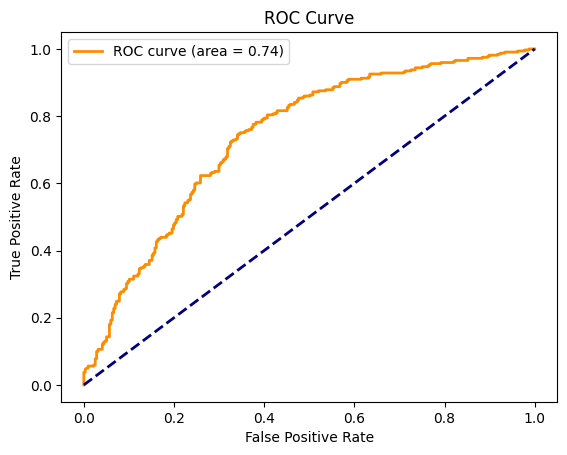

In [54]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

def create_model(input_dim):
    # Build the neural network
    model = Sequential()
    model.add(Dense(512, input_dim=input_dim, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

nn_model = create_model(X_train_tfidf.shape[1])

# Fit the model
nn_model.fit(X_train_tfidf.toarray(), y_train, epochs=10, batch_size=10, verbose=1)

# Evaluate the model
# Convert predictions to labels
y_proba = nn_model.predict(X_val_tfidf.toarray()).flatten()
y_pred = np.where(y_proba > 0.5, 1, 0)

accuracy, precision, recall, f1, roc_auc, fpr, tpr = model_evaluation(y_val, y_pred, y_proba)
model_results["Neural Network"] = [accuracy, precision, recall, f1, roc_auc, fpr, tpr]

BERT

In [55]:
from transformers import BertTokenizerFast,TFBertModel

# Import the BERT model
bert_tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')
bert = TFBertModel.from_pretrained("bert-base-uncased")

# Tokenization
train_encodings = bert_tokenizer(list(X_train), truncation=True, padding="max_length", max_length=128)
val_encodings = bert_tokenizer(list(X_val), truncation=True, padding="max_length", max_length=128)
train_dataset = tf.data.Dataset.from_tensor_slices((
      dict(train_encodings),
      y_train
  ))
val_dataset = tf.data.Dataset.from_tensor_slices((
      dict(val_encodings),
      y_val
))

# Classifier head
class Embedding_LSTM(keras.Model):
  def __init__(self, encoder, train_encoder=True):
    super(Embedding_LSTM, self).__init__()
    self.encoder = encoder
    self.encoder.trainable = train_encoder
    self.lstm = layers.LSTM(32)
    self.dropout1 = layers.Dropout(0.1)
    self.dense1 = layers.Dense(64, activation="relu")
    self.dropout2 = layers.Dropout(0.1)
    self.dense2 = layers.Dense(2, activation='softmax')

  def call(self, input):
    x = self.encoder(input)
    x = self.lstm(x['last_hidden_state'])
    x = self.dropout1(x)
    x = self.dense1(x)
    x = self.dropout2(x)
    x = self.dense2(x)
    return x

embedding_lstm = Embedding_LSTM(bert)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [56]:
def train_model(model, early_stopping_callback, train_dataset, batch_size=32, num_epochs=20):
  model.compile(
    tf.keras.optimizers.Adam(learning_rate=5e-5),
    "sparse_categorical_crossentropy",
    metrics=["accuracy"])

  history = model.fit(
    train_dataset.shuffle(1000).batch(batch_size),
    epochs=num_epochs,
    callbacks=[early_stopping_callback]
  )

  return history

In [57]:
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model
train_model(embedding_lstm, early_stopping_callback, train_dataset, 32, 50)

Epoch 1/50


80/80 [==============================] - ETA: 0s - loss: 0.5713 - accuracy: 0.7089

80/80 [==============================] - 97s 513ms/step - loss: 0.5713 - accuracy: 0.7089
Epoch 2/50
80/80 [==============================] - ETA: 0s - loss: 0.3683 - accuracy: 0.8570

80/80 [==============================] - 41s 507ms/step - loss: 0.3683 - accuracy: 0.8570
Epoch 3/50
80/80 [==============================] - ETA: 0s - loss: 0.2125 - accuracy: 0.9287

80/80 [==============================] - 41s 509ms/step - loss: 0.2125 - accuracy: 0.9287
Epoch 4/50
80/80 [==============================] - ETA: 0s - loss: 0.1220 - accuracy: 0.9651

80/80 [==============================] - 41s 511ms/step - loss: 0.1220 - accuracy: 0.9651
Epoch 5/50
80/80 [==============================] - ETA: 0s - loss: 0.0965 - accuracy: 0.9702

80/80 [==============================] - 41s 511ms/step - loss: 0.0965 - accuracy: 0.9702
Epoch 6/50
80/80 [==============================] - ETA: 0s - loss: 0.0673 - accuracy: 0.9835

80/80 [==============================] - 41s 509ms/step - loss: 0.0673 - accuracy: 0.9835
Epoch 7/50
80/80 [==============================] - ETA: 0s - loss: 0.0607 - accuracy: 0.9816

80/80 [==============================] - 41s 509ms/step - loss: 0.0607 - accuracy: 0.9816
Epoch 8/50
80/80 [==============================] - ETA: 0s - loss: 0.0650 - accuracy: 0.9792

80/80 [==============================] - 41s 512ms/step - loss: 0.0650 - accuracy: 0.9792
Epoch 9/50
80/80 [==============================] - ETA: 0s - loss: 0.0400 - accuracy: 0.9890

80/80 [==============================] - 41s 511ms/step - loss: 0.0400 - accuracy: 0.9890
Epoch 10/50
80/80 [==============================] - ETA: 0s - loss: 0.0343 - accuracy: 0.9910

80/80 [==============================] - 41s 512ms/step - loss: 0.0343 - accuracy: 0.9910
Epoch 11/50
80/80 [==============================] - ETA: 0s - loss: 0.0211 - accuracy: 0.9945

80/80 [==============================] - 41s 508ms/step - loss: 0.0211 - accuracy: 0.9945
Epoch 12/50
80/80 [==============================] - ETA: 0s - loss: 0.0231 - accuracy: 0.9945

80/80 [==============================] - 41s 508ms/step - loss: 0.0231 - accuracy: 0.9945
Epoch 13/50
80/80 [==============================] - ETA: 0s - loss: 0.0173 - accuracy: 0.9957

80/80 [==============================] - 41s 511ms/step - loss: 0.0173 - accuracy: 0.9957
Epoch 14/50
80/80 [==============================] - ETA: 0s - loss: 0.0425 - accuracy: 0.9855

80/80 [==============================] - 41s 508ms/step - loss: 0.0425 - accuracy: 0.9855
Epoch 15/50
80/80 [==============================] - ETA: 0s - loss: 0.0298 - accuracy: 0.9933

80/80 [==============================] - 41s 510ms/step - loss: 0.0298 - accuracy: 0.9933
Epoch 16/50
80/80 [==============================] - ETA: 0s - loss: 0.0259 - accuracy: 0.9914

80/80 [==============================] - 41s 514ms/step - loss: 0.0259 - accuracy: 0.9914
Epoch 17/50
80/80 [==============================] - ETA: 0s - loss: 0.0183 - accuracy: 0.9957

80/80 [==============================] - 41s 508ms/step - loss: 0.0183 - accuracy: 0.9957
Epoch 18/50
80/80 [==============================] - ETA: 0s - loss: 0.0139 - accuracy: 0.9976

80/80 [==============================] - 41s 510ms/step - loss: 0.0139 - accuracy: 0.9976
Epoch 19/50
80/80 [==============================] - ETA: 0s - loss: 0.0074 - accuracy: 0.9984

80/80 [==============================] - 41s 509ms/step - loss: 0.0074 - accuracy: 0.9984
Epoch 20/50
80/80 [==============================] - ETA: 0s - loss: 0.0061 - accuracy: 0.9988

80/80 [==============================] - 41s 510ms/step - loss: 0.0061 - accuracy: 0.9988
Epoch 21/50
80/80 [==============================] - ETA: 0s - loss: 0.0102 - accuracy: 0.9980

80/80 [==============================] - 41s 508ms/step - loss: 0.0102 - accuracy: 0.9980
Epoch 22/50
80/80 [==============================] - ETA: 0s - loss: 0.0065 - accuracy: 0.9984

80/80 [==============================] - 41s 510ms/step - loss: 0.0065 - accuracy: 0.9984
Epoch 23/50
80/80 [==============================] - ETA: 0s - loss: 0.0227 - accuracy: 0.9941

80/80 [==============================] - 41s 507ms/step - loss: 0.0227 - accuracy: 0.9941
Epoch 24/50
80/80 [==============================] - ETA: 0s - loss: 0.0169 - accuracy: 0.9961

80/80 [==============================] - 41s 511ms/step - loss: 0.0169 - accuracy: 0.9961
Epoch 25/50
80/80 [==============================] - ETA: 0s - loss: 0.0306 - accuracy: 0.9910

80/80 [==============================] - 41s 509ms/step - loss: 0.0306 - accuracy: 0.9910
Epoch 26/50
80/80 [==============================] - ETA: 0s - loss: 0.0184 - accuracy: 0.9922

80/80 [==============================] - 41s 510ms/step - loss: 0.0184 - accuracy: 0.9922
Epoch 27/50
80/80 [==============================] - ETA: 0s - loss: 0.0114 - accuracy: 0.9961

80/80 [==============================] - 41s 511ms/step - loss: 0.0114 - accuracy: 0.9961
Epoch 28/50
80/80 [==============================] - ETA: 0s - loss: 0.0103 - accuracy: 0.9965

80/80 [==============================] - 41s 509ms/step - loss: 0.0103 - accuracy: 0.9965
Epoch 29/50
80/80 [==============================] - ETA: 0s - loss: 0.0159 - accuracy: 0.9961

80/80 [==============================] - 41s 509ms/step - loss: 0.0159 - accuracy: 0.9961
Epoch 30/50
80/80 [==============================] - ETA: 0s - loss: 0.0030 - accuracy: 0.9996

80/80 [==============================] - 41s 510ms/step - loss: 0.0030 - accuracy: 0.9996
Epoch 31/50
80/80 [==============================] - ETA: 0s - loss: 0.0163 - accuracy: 0.9965

80/80 [==============================] - 41s 509ms/step - loss: 0.0163 - accuracy: 0.9965
Epoch 32/50
80/80 [==============================] - ETA: 0s - loss: 0.0148 - accuracy: 0.9961

80/80 [==============================] - 41s 511ms/step - loss: 0.0148 - accuracy: 0.9961
Epoch 33/50
80/80 [==============================] - ETA: 0s - loss: 0.0088 - accuracy: 0.9980

80/80 [==============================] - 41s 509ms/step - loss: 0.0088 - accuracy: 0.9980
Epoch 34/50
80/80 [==============================] - ETA: 0s - loss: 0.0108 - accuracy: 0.9976

80/80 [==============================] - 41s 511ms/step - loss: 0.0108 - accuracy: 0.9976
Epoch 35/50
80/80 [==============================] - ETA: 0s - loss: 0.0141 - accuracy: 0.9961

80/80 [==============================] - 41s 509ms/step - loss: 0.0141 - accuracy: 0.9961
Epoch 36/50
80/80 [==============================] - ETA: 0s - loss: 0.0179 - accuracy: 0.9953

80/80 [==============================] - 41s 512ms/step - loss: 0.0179 - accuracy: 0.9953
Epoch 37/50
80/80 [==============================] - ETA: 0s - loss: 0.0170 - accuracy: 0.9949

80/80 [==============================] - 41s 513ms/step - loss: 0.0170 - accuracy: 0.9949
Epoch 38/50
80/80 [==============================] - ETA: 0s - loss: 0.0064 - accuracy: 0.9984

80/80 [==============================] - 41s 511ms/step - loss: 0.0064 - accuracy: 0.9984
Epoch 39/50
80/80 [==============================] - ETA: 0s - loss: 0.0074 - accuracy: 0.9965

80/80 [==============================] - 41s 514ms/step - loss: 0.0074 - accuracy: 0.9965
Epoch 40/50
80/80 [==============================] - ETA: 0s - loss: 0.0073 - accuracy: 0.9976

80/80 [==============================] - 41s 510ms/step - loss: 0.0073 - accuracy: 0.9976
Epoch 41/50
80/80 [==============================] - ETA: 0s - loss: 0.0078 - accuracy: 0.9980

80/80 [==============================] - 41s 508ms/step - loss: 0.0078 - accuracy: 0.9980
Epoch 42/50
80/80 [==============================] - ETA: 0s - loss: 0.0100 - accuracy: 0.9957

80/80 [==============================] - 41s 510ms/step - loss: 0.0100 - accuracy: 0.9957
Epoch 43/50
80/80 [==============================] - ETA: 0s - loss: 0.0126 - accuracy: 0.9961

80/80 [==============================] - 41s 509ms/step - loss: 0.0126 - accuracy: 0.9961
Epoch 44/50
80/80 [==============================] - ETA: 0s - loss: 0.0082 - accuracy: 0.9984

80/80 [==============================] - 41s 510ms/step - loss: 0.0082 - accuracy: 0.9984
Epoch 45/50
80/80 [==============================] - ETA: 0s - loss: 0.0403 - accuracy: 0.9906

80/80 [==============================] - 41s 510ms/step - loss: 0.0403 - accuracy: 0.9906
Epoch 46/50
80/80 [==============================] - ETA: 0s - loss: 0.0181 - accuracy: 0.9953

80/80 [==============================] - 41s 508ms/step - loss: 0.0181 - accuracy: 0.9953
Epoch 47/50
80/80 [==============================] - ETA: 0s - loss: 0.0078 - accuracy: 0.9980

80/80 [==============================] - 41s 511ms/step - loss: 0.0078 - accuracy: 0.9980
Epoch 48/50
80/80 [==============================] - ETA: 0s - loss: 0.0078 - accuracy: 0.9976

80/80 [==============================] - 41s 512ms/step - loss: 0.0078 - accuracy: 0.9976
Epoch 49/50
80/80 [==============================] - ETA: 0s - loss: 0.0084 - accuracy: 0.9965

80/80 [==============================] - 41s 510ms/step - loss: 0.0084 - accuracy: 0.9965
Epoch 50/50
80/80 [==============================] - ETA: 0s - loss: 0.0102 - accuracy: 0.9965

80/80 [==============================] - 41s 509ms/step - loss: 0.0102 - accuracy: 0.9965


20/20 [==============================] - 11s 141ms/step
Classification report for Random Forest:
              precision    recall  f1-score   support

           0       0.76      0.70      0.73       317
           1       0.73      0.78      0.75       321

    accuracy                           0.74       638
   macro avg       0.74      0.74      0.74       638
weighted avg       0.74      0.74      0.74       638

ROC AUC for Random Forest: 0.8058020578436864


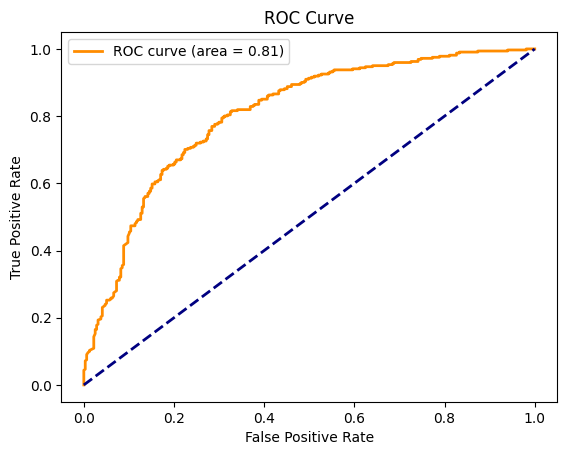

In [58]:
# Evaluate the model
logits = embedding_lstm.predict(val_dataset.batch(32))
y_proba = logits[:, 1]
y_pred = np.argmax(logits, axis=1)

accuracy, precision, recall, f1, roc_auc, fpr, tpr = model_evaluation(y_val, y_pred, y_proba)
model_results["BERT"] = [accuracy, precision, recall, f1, roc_auc, fpr, tpr]

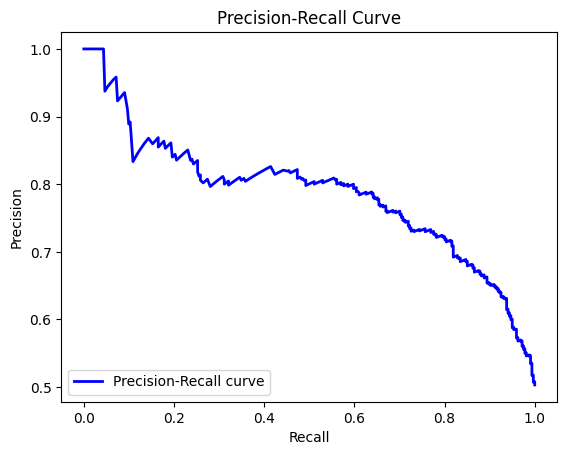

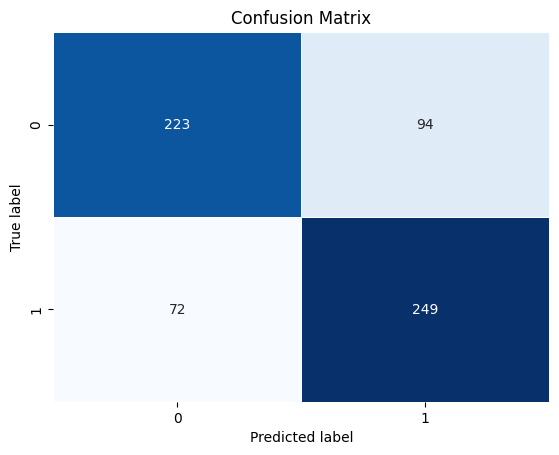

In [73]:
from sklearn.metrics import confusion_matrix, precision_recall_curve

# Calculate Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_val, y_proba)

# Plot Precision-Recall Curve
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()

# Confusion Matrix
cm = confusion_matrix(y_val, y_pred)
sns.heatmap(cm, annot=True, fmt="d", linewidths=.5, cmap='Blues', cbar=False)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.show()

**8. Result Visualization**

In [59]:
# Display the accuracy, precision, recall, f1-score, AUC score of models
model_results = pd.DataFrame(model_results, index=["Accuracy", "Precision", "Recall", "F1-score", "ROC AUC", "fpr", "tpr"])
model_results.head()

,Logistic Regression,SVM,Random Forest,Voting Classifier,Neural Network,BERT
Accuracy,0.738245,0.731975,0.703762,0.72884,0.677116,0.739812
Precision,0.730539,0.734375,0.697605,0.735669,0.686084,0.725948
Recall,0.760125,0.732087,0.725857,0.719626,0.660436,0.775701
F1-score,0.745038,0.733229,0.71145,0.727559,0.673016,0.75
ROC AUC,0.784958,0.788457,0.762282,0.789312,0.740013,0.805802


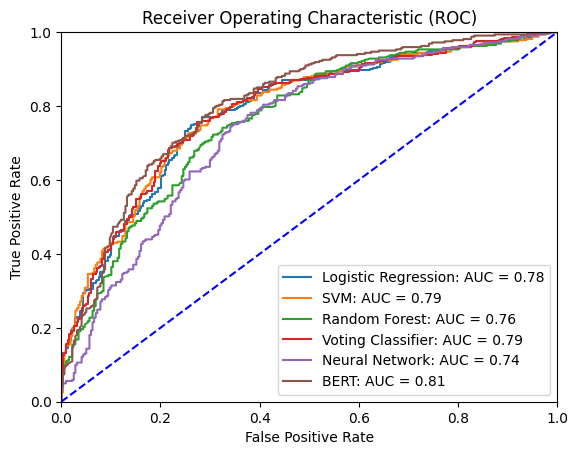

In [69]:
# Display the ROC curve of models
plt.title('Receiver Operating Characteristic (ROC)')
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']
for name, color in zip(model_results.columns, colors):
  plt.plot(model_results[name].loc["fpr"],
           model_results[name].loc["tpr"],
           color=color,
           label=name + ': AUC = %0.2f' % model_results[name].loc["ROC AUC"])

plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1], 'b--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()